https://www.kaggle.com/datasets/andrewmvd/animal-faces

### Импорт всех необходимых библиотек

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision import transforms
from torchvision.models import vgg16
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os
from typing import Any, Tuple

from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import Dataset, DataLoader

In [2]:
CPU_CORES = 0 # c albumentations не удается работать параллельно
PREPROC_BATCH_SIZE = 16
TRAIN_BATCH_SIZE = 128
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Предобработка

In [3]:
pre_transform_train = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(224) # размер входа VGG https://arxiv.org/pdf/1409.1556.pdf
    ]
)

In [4]:
pre_train_dataset = ImageFolder(root='train', transform=pre_transform_train)
pre_train_dataset

Dataset ImageFolder
    Number of datapoints: 14630
    Root location: train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
           )

In [5]:
pre_train_dataloader = DataLoader(pre_train_dataset, batch_size=PREPROC_BATCH_SIZE, shuffle=True, num_workers=8)
size = next(iter(pre_train_dataloader))[0].shape
size

torch.Size([16, 3, 224, 224])

In [6]:
sum = torch.tensor([0.,0.,0.])
for x,y in pre_train_dataloader:
    sum += x.sum(axis=0).sum(1).sum(1)

mean = sum / (size[2]*size[3]*len(pre_train_dataset))
mean #среднее

tensor([0.5022, 0.4599, 0.3994])

In [7]:
sum = torch.tensor([0.,0.,0.])
for x,y in pre_train_dataloader:
    for t in x:
        sum += (t.sum(1).sum(1)/(size[2]*size[3]*PREPROC_BATCH_SIZE) - mean)**2


In [8]:
sum

tensor([3243.4031, 2720.0522, 2051.4001])

In [9]:

std = torch.sqrt(sum/len(pre_train_dataset))
std # дисперсия

tensor([0.4708, 0.4312, 0.3745])

### Ресайз, нормализация и аугументация

In [10]:
train_transform = A.Compose(
    [
        A.Resize(224,224), #размер входа VGG
        A.Normalize(mean=mean.tolist(),
                             std=std.tolist()),
                        
        A.GaussianBlur(blur_limit=(1,3), p=0.3),
        A.RandomBrightnessContrast(),
        
        ToTensorV2(),
    ]
)

transform_test = A.Compose(
    [
        A.Resize(224,224), #размер входа VGG
        A.Normalize(mean=mean.tolist(),
                             std=std.tolist()),
        ToTensorV2(),
    ]
)

### Чтение файлов в датасет и применения трансформаций

In [11]:
# класс для применения трансформаций с albumentations
class CustomImageFolder(ImageFolder):
    def __init__(
        self,
        root: str,
        transform: A.Compose = None,
    ):
        super().__init__(
            root,
            transform=transform
        )
    

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """

        path, target = self.samples[index]
        if self.target_transform is not None:
            target = self.target_transform(target)
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)["image"] # вызов трансформаций с albumentations
        return image, target

In [12]:
train_dataset = CustomImageFolder(root='train', transform=train_transform)
test_dataset = CustomImageFolder(root='val', transform=transform_test)

In [13]:
train_dataset

Dataset CustomImageFolder
    Number of datapoints: 14630
    Root location: train
    StandardTransform
Transform: Compose([
             Resize(always_apply=False, p=1, height=224, width=224, interpolation=1),
             Normalize(always_apply=False, p=1.0, mean=[0.5021811127662659, 0.45988523960113525, 0.3993526101112366], std=[0.47084537148475647, 0.43118780851364136, 0.3744579255580902], max_pixel_value=255.0),
             GaussianBlur(always_apply=False, p=0.3, blur_limit=(1, 3), sigma_limit=(0, 0)),
             RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
             ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
           ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

### Объявление даталоадеров

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True, num_workers=CPU_CORES, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True, num_workers=CPU_CORES, pin_memory=True)

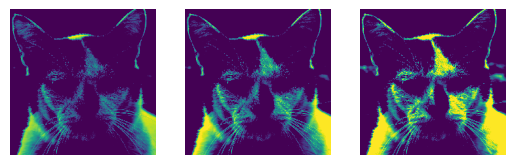

In [15]:
for_show = next(iter(train_dataloader))[0]

f = plt.figure()
for i in range(3):
    f.add_subplot(1, 3, i + 1)
    plt.imshow(for_show.numpy()[0][i])
    plt.axis('off')

### Инициализация претренированной сети vgg 16 и изменение последнего слоя

In [16]:
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
for p in model.parameters():
    p.requires_grad = False

In [18]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [19]:
model.classifier[6] = torch.nn.Linear(4096,3)
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
          [-5.8312e-01,  3.5655e-01,  7.6566e-01],
          [-6.9022e-01, -4.8019e-02,  4.8409e-01]],

         [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
          [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
          [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],

         [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
          [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
          [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],


        [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
          [-4.2805e-01, -2.4349e-01,  2.4628e-01],
          [-2.5066e-01,  1.4177e-01, -5.4864e-03]],

         [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
          [-8.4127e-01, -3.5176e-01,  5.6398e-01],
          [-2.4194e-01,  5.1928e-01,  5.3915e-01]],

         [[-3.1432e-01, -3.7048e-01, -1.3094e-01],
          [-4.7144e-01, -1.5503e-01,  3.4589e-01],
          [ 5.4384e-02,  5.8683e-01,  4.9580e-01]]],


        [[[ 1.7715e-01,  5.2149e-01,  9.8740

In [20]:
model = model.to(device)
model.forward(next(iter(train_dataloader))[0].to(device)).shape

torch.Size([128, 3])

In [21]:
num_epochs = 16
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)
### Используем скедулер для уменьшения лернинг рейта
scheduler = ReduceLROnPlateau(optimizer=optimizer, factor=0.5, patience=2, threshold=1e-3)

### Объявление loss функции

In [22]:
def loss_function(preds, true):
    loss = nn.CrossEntropyLoss()
    return loss(preds, true)

In [23]:
all_train_losses = []
all_test_losses = []

In [24]:
device

device(type='cuda', index=0)

### Обучение и визуализация процесса обучения

loss train 0.09892160550021288
loss test 0.008279448211066086


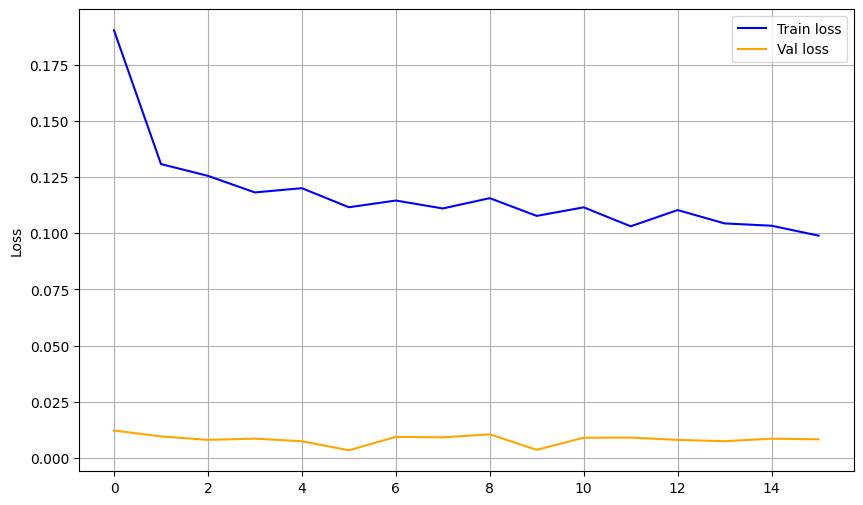

In [25]:
for epoch in range(num_epochs):
    train_loss = 0
    test_loss = 0
    model.train(True)
    print(f'epoch_number is {epoch}. Train')
    for (X, y) in tqdm(train_dataloader):
        model.zero_grad()
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        preds = model.forward(X)
        loss = loss_function(preds, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().item()/(len(train_dataloader))
    model.train(False)
    model.eval()
    print(f'epoch_number is {epoch}. Test')
    for (X, y) in tqdm(test_dataloader):
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        preds = model.forward(X)
        loss = loss_function(preds, y)
        test_loss += loss.detach().item()/(len(test_dataloader))
    scheduler.step(test_loss)
    clear_output()
    all_train_losses.append(train_loss)
    all_test_losses.append(test_loss)
    print('loss train', train_loss)
    print('loss test', test_loss)
    plt.figure(figsize = (10, 6))
    plt.plot(all_train_losses, label = 'Train loss', color = 'blue')
    plt.plot(all_test_losses, label = 'Val loss', color = 'orange')
    plt.legend()
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

### Вывод метрик модели

In [26]:
final_dataloader = DataLoader(test_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=False, drop_last=False)

In [27]:
preds = []
real = []
for x, y in final_dataloader:
    preds.append(model.forward(x.to(device)).detach().cpu().numpy())
    real.append(y.numpy())

In [28]:
final_preds = np.concatenate(preds).argmax(axis=1)
real = np.concatenate(real)

In [29]:
print(classification_report(real, final_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       500

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



### Сохранение модели

In [30]:
torch.save(model.state_dict(), 'model.pth')

### Загрузка модели

In [31]:
model2 = vgg16(weights=VGG16_Weights.DEFAULT)
model2.classifier[6] = torch.nn.Linear(4096,3)
model2.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

### Предсказание на тесте ( вообще функция подойдет для любой картинки, до нее нужно лишь указать путь)

In [32]:
dict_names = {
    0: 'Кошка',
    1: 'Собака',
    2: 'Дикая'
}

In [33]:
model2.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [34]:
def predict_by_path(path):
    image = Image.open(path)
    image_np =  np.array(image)
    pred = model2.forward(transform_test(image=image_np)["image"].unsqueeze(0)).cpu().detach().numpy()[0]
    plt.imshow(image)
    res = np.argmax(pred)
    print(dict_names[res])

Кошка


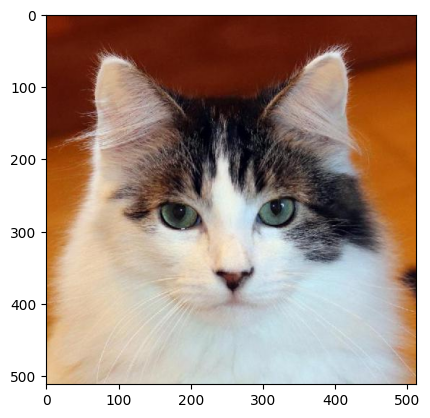

In [35]:
predict_by_path('val/cat/flickr_cat_000008.jpg')

Собака


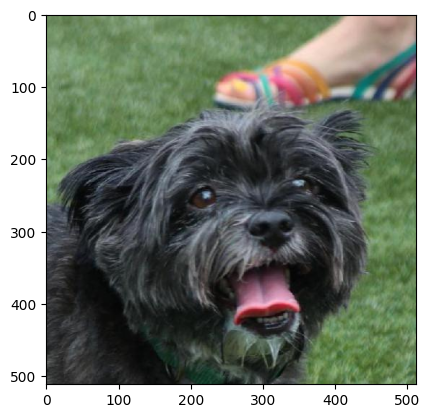

In [36]:
predict_by_path('val/dog/flickr_dog_000060.jpg')

Дикая


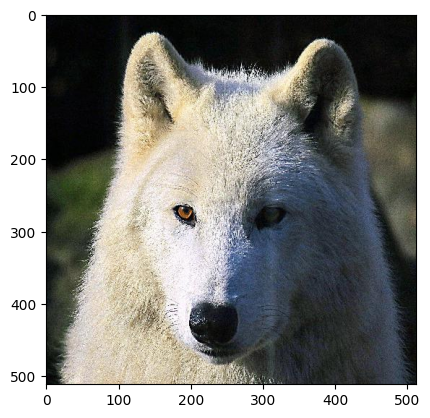

In [37]:
predict_by_path('val/wild/flickr_wild_000470.jpg')

### Заключение

Добученная модель VGG16 на тренировочных даных во врем яобучения показывает ошибку в 10%, однако на тестовом множестве около 1%.

Такая разница может быть обусловлена аугментацией изображения (наложения размытия по Гауссу) т.к. к тестовым данным оно не применяется.

Проврека на всем тестовом множестве показывает 100% точность модели.